<a href="https://colab.research.google.com/github/RafalDoroz/ai/blob/main/shap-basic-guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import wszystkich wymaganych bibliotek

In [20]:
# W Google Colab trzeba najpierw zainstalowaƒá bibliotekƒô SHAP (odkomentuj poni≈ºszƒÖ liniƒô):
! pip install shap

In [21]:
# Import biblioteki SHAP (do oblicze≈Ñ warto≈õci Shapleya i wizualizacji)
import shap

# Implementacja XGBoost do modelu regresji/drzew
import xgboost

# Funkcja z Scikit-learn do podzia≈Çu zbioru na treningowy i testowy
from sklearn.model_selection import train_test_split

# Funkcja z Scikit-learn do obliczania ≈õredniego b≈Çƒôdu kwadratowego (MSE)
from sklearn.metrics import mean_squared_error


# 2.  Za≈Çaduj przyk≈Çadowy zbi√≥r danych

Bƒôdziemy korzystaƒá z California housing dataset (https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)

In [22]:
# X to cechy, a y to warto≈õci docelowe
X, y = shap.datasets.california()

Podzielmy dane na zbi√≥r treningowy (80%) i testowy (20%):

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3. Wytrenuj model XGBoost

Inicjalizacja modelu XGBoost (regresja):



In [25]:
model = xgboost.XGBRegressor()

Uczenie modelu na danych treningowych:

In [6]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Predykcja na zbiorze testowym:

In [7]:
predictions = model.predict(X_test)

Obliczenie b≈Çƒôdu (MSE):

In [8]:
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 0.207833


# 4. Wyja≈õnianie modelu XGBoost za pomocƒÖ biblioteki SHAP

## 4.1. Szacowanie warto≈õci Shapleya

Tworzymy explainer, kt√≥ry policzy warto≈õci Shapleya:

U≈ºywamy zbi√≥r treningowy X_train do oblicze≈Ñ

In [9]:
explainer = shap.Explainer(model=model, masker=X_train)

Sprawdzamy klasƒô explainer‚Äôa (powinno pokazaƒá TreeExplainer):

In [23]:
explainer.__class__

shap.explainers._tree.TreeExplainer

Liczymy warto≈õci Shapleya dla zbioru testowego:

In [11]:
shap_values = explainer(X_test)

100%|===================| 4122/4128 [00:25<00:00]       

## 4.2. Local explanations

Wyja≈õnienia lokalne (dla pojedynczych prognoz)

### Waterfall Plot

Waterfall Plot ‚Äì pokazuje, jak cecha po cesze ‚Äûdodaje‚Äù lub ‚Äûodejmuje‚Äù od warto≈õci bazowej (base_value):

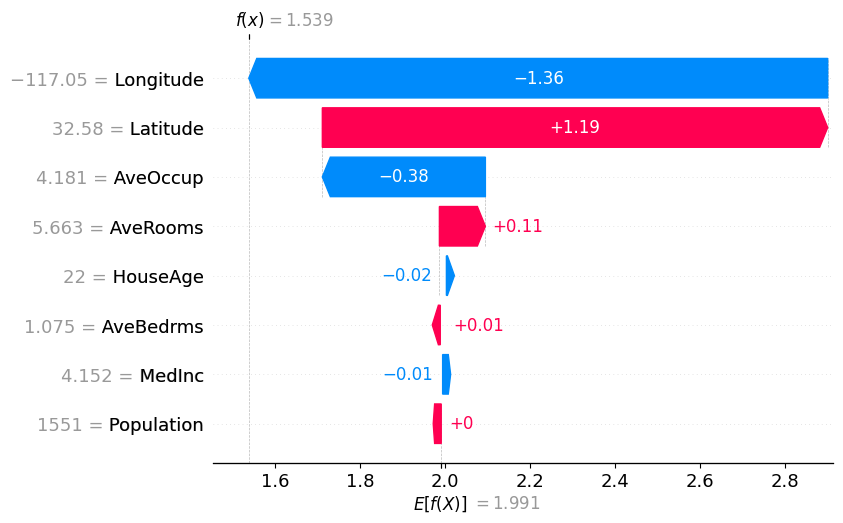

In [12]:
shap.plots.waterfall(shap_values[0])

**Co widaƒá na wykresie?**
f(x) = 1.539 ‚Äì to wynik modelu (dla konkretnej obserwacji).

E[f(X)] = 1.991 ‚Äì to warto≈õƒá bazowa (baseline), czyli ≈õrednia prognoza modelu dla wszystkich danych treningowych.

Czerwone i niebieskie ‚Äûpaski‚Äù ‚Äì to wk≈Çad poszczeg√≥lnych cech (SHAP values):

üî¥ Czerwony pasek (warto≈õƒá dodatnia) ‚Äì cecha podnosi przewidywanƒÖ warto≈õƒá (popycha wynik modelu w g√≥rƒô).

üîµ Niebieski pasek (warto≈õƒá ujemna) ‚Äì cecha obni≈ºa przewidywanƒÖ warto≈õƒá (popycha wynik modelu w d√≥≈Ç).

Po lewej widzimy konkretne warto≈õci cech (np. Longitude = -117.05, Latitude = 32.58).

Ka≈ºda cecha ma obok siebie liczbƒô, np. -1.36, +1.19, -0.38 ‚Äì to warto≈õƒá SHAP (ile ta cecha zmienia wynik).

---


**Jak to czytaƒá?**

1Ô∏è. Zaczynamy od warto≈õci bazowej (E[f(X)] = 1.991)
‚û° Model ‚Äûna starcie‚Äù przewiduje ≈õredniƒÖ warto≈õƒá z danych treningowych.

2Ô∏è. Dodajemy wk≈Çad ka≈ºdej cechy

Longitude = -117.05 ‚Üí ‚Äì1.36 ‚Äì silnie obni≈ºa wynik.

Latitude = 32.58 ‚Üí +1.19 ‚Äì prawie r√≥wnowa≈ºy wp≈Çyw Longitude, mocno podnosi wynik.

AveOccup = 4.181 ‚Üí ‚Äì0.38 ‚Äì te≈º trochƒô obni≈ºa wynik.

Pozosta≈Çe cechy majƒÖ niewielki wp≈Çyw (np. AveRooms = +0.11, HouseAge = -0.02).

3Ô∏è. Ko≈Ñcowy wynik modelu
‚û° Wszystkie SHAP values sƒÖ sumowane:
Warto≈õƒá bazowa 1.991 + suma wp≈Çyw√≥w (-1.36 + 1.19 - 0.38 + 0.11 ‚Ä¶) = f(x) = 1.539.

---

Co nam to m√≥wi o tym konkretnym przypadku?
Najwa≈ºniejszy wp≈Çyw mia≈Çy:

- Longitude ‚Äì obni≈ºy≈Ç prognozƒô a≈º o 1.36 jednostki.

- Latitude ‚Äì podni√≥s≈Ç prognozƒô o 1.19 jednostki.

Cecha AveOccup (≈õrednia liczba mieszka≈Ñc√≥w w domu) ‚Äì trochƒô obni≈ºy≈Ça prognozƒô.

Pozosta≈Çe cechy (AveRooms, HouseAge, AveBedrms, MedInc, Population) mia≈Çy marginalny wp≈Çyw.

**Jak interpretowaƒá takie wykresy og√≥lnie?**
Cel:
Wyja≈õniƒá dlaczego model przewidzia≈Ç takƒÖ warto≈õƒá dla konkretnej obserwacji.

**Interpretacja kolor√≥w:**

üî¥ Czerwone paski ‚Äì cechy ukierunkowujƒÖ wynik modelu w stronƒô wy≈ºszej prognozy.

üîµ Niebieskie paski ‚Äì cechy ukierunkowujƒÖ wynik modelu w stronƒô ni≈ºszej prognozy.

### Force Plot

Interaktywna wizualizacja warto≈õci Shapleya:

Wizualizacja warto≈õci Shapleya dla prognozy pierwszego przypadku w  zestawie danych testowych przy u≈ºyciu wykresu si≈Çowego

In [24]:
shap.initjs()
shap.plots.force(shap_values[0])

**Jak czytaƒá taki wykres?**

1. Linia bazowa

base value = 1.991 ‚Äì to ≈õrednia prognoza modelu dla wszystkich danych treningowych.
‚û° To punkt startowy, od kt√≥rego model ‚Äûzaczyna‚Äù obliczanie przewidywania.

2. Wynik modelu (f(x))
f(x) = 1.54 ‚Äì to ostateczna predykcja modelu dla tej konkretnej obserwacji.

3. Strza≈Çki i kolory

üî¥ Czerwone strza≈Çki ‚Üí cechy, kt√≥re zwiƒôkszajƒÖ przewidywanƒÖ warto≈õƒá.

üîµ Niebieskie strza≈Çki ‚Üí cechy, kt√≥re obni≈ºajƒÖ przewidywanƒÖ warto≈õƒá.

D≈Çugo≈õƒá strza≈Çki = si≈Ça wp≈Çywu cechy (warto≈õƒá SHAP).

---

üìä Interpretacja wykresu

AveRooms = 5.663 (czerwony) ‚Äì ta cecha podnios≈Ça wynik modelu (przesunƒô≈Ça go w stronƒô wy≈ºszych warto≈õci).

Latitude = 32.58 (czerwony) ‚Äì r√≥wnie≈º zwiƒôkszy≈Ça przewidywanƒÖ warto≈õƒá.

Longitude = -117 (niebieski) ‚Äì obni≈ºy≈Ç wynik modelu (du≈ºy wp≈Çyw ujemny).

AveOccup = 4.181 (niebieski) ‚Äì tak≈ºe ‚ÄûpociƒÖgnƒÖ≈Ç‚Äù wynik w d√≥≈Ç, ale s≈Çabiej.

---

**Co z tego wynika?**

‚û° Model zaczyna od warto≈õci bazowej (1.991).
‚û° Dodaje wp≈Çyw czerwonych cech (np. AveRooms i Latitude).
‚û° Odejmowane sƒÖ wp≈Çywy niebieskich cech (Longitude i AveOccup).
‚û° SumujƒÖc to wszystko otrzymujemy ko≈ÑcowƒÖ prognozƒô (1.54).

---

Jak u≈ºywaƒá force plot w praktyce?

-Pokazuje dlaczego model wyda≈Ç takƒÖ decyzjƒô dla jednego konkretnego przypadku.

-Widaƒá, kt√≥re cechy majƒÖ najwiƒôkszy wp≈Çyw, a kt√≥re prawie nie zmieniajƒÖ wyniku.

-Pomaga w audytach modeli (np. czy model nie kieruje siƒô cechami, kt√≥re nie powinny wp≈Çywaƒá na decyzjƒô ‚Äì np. p≈Çeƒá, wiek).

## 4.3. Global explanations

Wyja≈õnienia globalne (dla ca≈Çego modelu)

### Bar Plot

Pokazuje ≈õredni wp≈Çyw ka≈ºdej cechy:

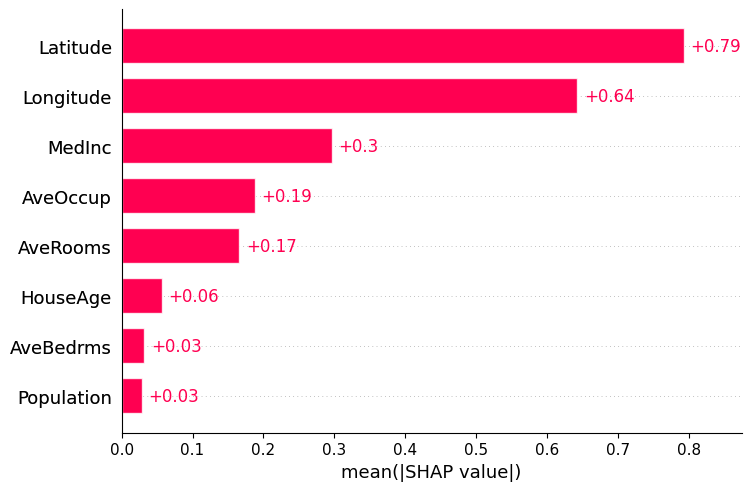

In [15]:
shap.plots.bar(shap_values)

Co oznacza ten wykres?

1. Ka≈ºdy pasek = jedna cecha

Latitude, Longitude, MedInc, AveOccup... ‚Äì to cechy modelu.

Kolejno≈õƒá jest ustalona od najwa≈ºniejszej (g√≥ra) do najmniej wa≈ºnej (d√≥≈Ç).

2. D≈Çugo≈õƒá paska = ≈õrednia bezwzglƒôdna warto≈õƒá SHAP (mean(|SHAP value|))

Mierzy, jak bardzo dana cecha wp≈Çywa≈Ça na predykcje modelu we wszystkich pr√≥bkach:

d≈Çugi pasek = cecha bardzo wa≈ºna,

kr√≥tki pasek = cecha prawie nie wp≈Çywa.


3. Liczby przy paskach

Np. +0.79 przy Latitude oznacza, ≈ºe ≈õredni wk≈Çad (bez wzglƒôdu na kierunek) tej cechy w decyzjƒô modelu to 0.79 jednostki wyniku modelu.


---



Interpretacja Twojego wykresu

Latitude (szeroko≈õƒá geograficzna) ‚Äì najwa≈ºniejsza cecha (≈õredni wk≈Çad ~0.79).

Longitude (d≈Çugo≈õƒá geograficzna) ‚Äì druga najwa≈ºniejsza cecha (~0.64).

MedInc (≈õredni doch√≥d) ‚Äì trzecia pod wzglƒôdem wa≈ºno≈õci (~0.30).

Pozosta≈Çe cechy (AveOccup, AveRooms, HouseAge, AveBedrms, Population) majƒÖ coraz mniejszy wp≈Çyw.


---


Jak u≈ºywaƒá takich wykres√≥w?

Do czego s≈Çu≈ºy?

Pokazuje globalnƒÖ interpretacjƒô modelu ‚Äì kt√≥re cechy najczƒô≈õciej wp≈ÇywajƒÖ na wyniki.

Pozwala na priorytetyzacjƒô cech ‚Äì np. w analizie biznesowej mo≈ºesz powiedzieƒá: ‚Äûmodel g≈Ç√≥wnie patrzy na szeroko≈õƒá i d≈Çugo≈õƒá geograficznƒÖ‚Äù.

Na co uwa≈ºaƒá?

Warto≈õƒá jest bezwzglƒôdna ‚Äì czyli niewa≈ºne, czy cecha podnosi≈Ça czy obni≈ºa≈Ça wynik ‚Äì liczy siƒô sam wp≈Çyw.

To u≈õrednienie po wszystkich pr√≥bkach ‚Äì nie pokazuje r√≥≈ºnic lokalnych (np. w jednym przypadku Latitude mog≈Ça dzia≈Çaƒá pozytywnie, w innym negatywnie).



Mo≈ºemy ograniczyƒá liczbƒô wy≈õwietlanych cech:

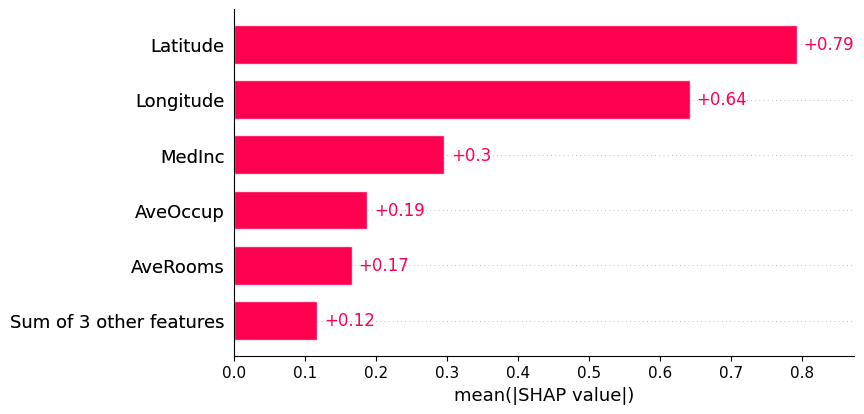

In [16]:
shap.plots.bar(shap_values, max_display=6)

### Beeswarm Plot

Ka≈ºdy punkt to jedna warto≈õƒá SHAP dla jednej obserwacji:

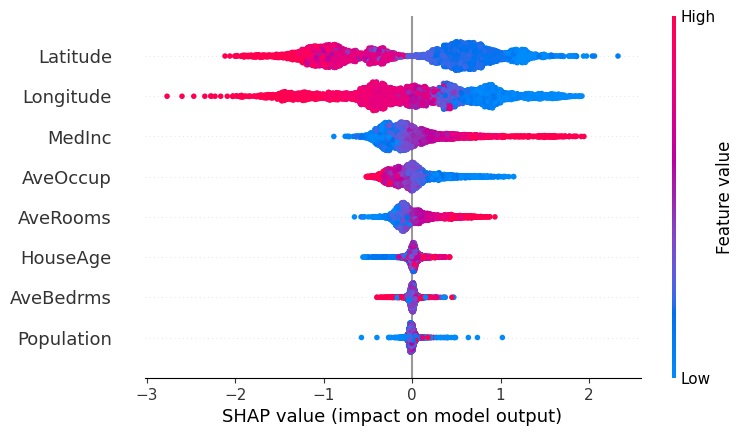

In [17]:
shap.plots.beeswarm(shap_values)

SHAP beeswarm plot, czyli wykres rojowy SHAP.


To jeden z najwa≈ºniejszych wykres√≥w w SHAP, bo daje globalny obraz modelu i jednocze≈õnie pokazuje rozk≈Çad warto≈õci cech.


---


Jak czytaƒá ten wykres?

1. Ka≈ºdy rzƒÖd to jedna cecha
Latitude, Longitude, MedInc, AveOccup‚Ä¶ ‚Äì cechy modelu.

Rzƒôdy sƒÖ uporzƒÖdkowane od najwa≈ºniejszej do najmniej wa≈ºnej (tak jak w bar plot).

2. Ka≈ºda kropka = jedna obserwacja
Kropka pokazuje warto≈õƒá SHAP dla danej cechy w jednej pr√≥bce:

Po≈Ço≈ºenie w poziomie (o≈õ X) = wp≈Çyw cechy na wynik modelu:

warto≈õƒá SHAP > 0 ‚Üí cecha pcha przewidywanie w g√≥rƒô,

warto≈õƒá SHAP < 0 ‚Üí cecha pcha przewidywanie w d√≥≈Ç.

Kolor kropki = warto≈õƒá cechy:

üî¥ czerwony = wysoka warto≈õƒá cechy,

üîµ niebieski = niska warto≈õƒá cechy.

3. Gƒôsto≈õƒá kropek = ‚Äûkszta≈Çt chmury‚Äù

Im wiƒôcej kropek w danym miejscu, tym bardziej model ‚Äûskupia‚Äù swoje decyzje wok√≥≈Ç tych warto≈õci SHAP.

Interpretacja Twojego wykresu

Latitude (szeroko≈õƒá geograficzna):

Czerwone kropki (wysoka warto≈õƒá) sƒÖ po lewej ‚Äì wysokie warto≈õci latitude obni≈ºajƒÖ wynik modelu.

Niebieskie kropki (niskie warto≈õci) sƒÖ po prawej ‚Äì niskie latitude podnoszƒÖ wynik modelu.

Longitude (d≈Çugo≈õƒá geograficzna):

Analogicznie ‚Äì model wyra≈∫nie reaguje na d≈Çugo≈õƒá geograficznƒÖ.

MedInc (≈õredni doch√≥d):

Czerwone punkty przesuwajƒÖ siƒô w prawo ‚Üí wysoki doch√≥d zwiƒôksza przewidywanie.

Cechy ni≈ºej (HouseAge, AveBedrms, Population):

Wp≈Çyw jest minimalny (chmury wƒÖskie, skupione przy 0).


---


üìñ Co nam daje beeswarm plot?
‚úÖ Globalne spojrzenie ‚Äì widzimy:

kt√≥re cechy sƒÖ najwa≈ºniejsze (pozycja na li≈õcie),

jaki jest zakres ich wp≈Çywu (rozciƒÖgniƒôcie kropek na osi X),

kierunek wp≈Çywu (czy wysokie warto≈õci cechy ‚ÄûpopychajƒÖ‚Äù wynik w g√≥rƒô czy w d√≥≈Ç).

‚úÖ Kolor dodaje kontekst ‚Äì od razu widaƒá, czy ‚Äûwysokie warto≈õci‚Äù cechy zwiƒôkszajƒÖ czy zmniejszajƒÖ przewidywanie modelu.

### Force Plot

Wizualizacja dla pierwszych 100 predykcji:

In [18]:
shap.initjs()
shap.plots.force(shap_values[0:100])